# Affine Matrix Function (`traceinv`, `logdet`, with or without `gram`)


### Objective

To compute:

* $\mathrm{trace}(\mathbf{A} + t \mathbf{I})^{-1}$,
* $\mathrm{trace}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})^{-1}$,
* $\mathrm{logdet}(\mathbf{A} + t \mathbf{I})$,
* $\mathrm{logdet}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})$,

where the parameter $t$ is varied.

This notebook will plot

* Accuracy of computing traceinv when compared with analytic solution for this matrix for each $t$.

### Matrix

Matrix $\mathbf{A} = \mathbf{M}^{\intercal} \mathbf{M}$ is a symmetric 3-band matrix and $\mathbf{M}$ is a 2-band matrix defined by

$$
    M_{ij} = 
    \begin{cases}
        \alpha, & i = j, \\
        \beta, & i+1 = j.
    \end{cases}
$$

### Consideratons

**parameters:**
* $\alpha = 2$, $\beta = 1$
* In SLQ method, `min_num_samples` and `max_num_samples` are fixed to 200.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.
* Each result is repeated 10 times and the wall time is averaged between these 10 repeats.
* The results of all three methods are compared with the their exact value using *Cholesky* method.

**Notes:**

* Matrix is generated as sparse CSR.
* Only 64-bit data type is used.
* For each function (`traceinv`, or `logdet`), two set of matrices are computed:
    * If `gram=False`, input matrix is $\mathbf{A} = \mathbf{M}^{\intercal} \mathbf{M}$, and we compute traceinv or logdet of $\mathbf{A} + t \mathbf{I}$.
    * If `gram=True`, input matrix is $\mathbf{A} = \mathbf{M}$, and we compute traceinv or logdet of $\mathbf{A}^{\intercal} \mathbf{A} + t \mathbf{I}$.
   
  Essentially, both two matrices in the above are the same, just the *input* matrix to the SLQ method differs.
* The process time of `gram=True` is twice `gram=False`.

### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/affine_matrix_function.py` by

    cd /benchmark/scripts
    python ./affine_matrix_function.py -f traceinv         # traceinv(A + tI)
    python ./affine_matrix_function.py -f traceinv -g      # traceinv(A.T @ A + tI)
    python ./affine_matrix_function.py -f logdet           # logdet(A + tI)
    python ./affine_matrix_function.py -f logdet -g        # logdet(A.T @ A + tI)
    
The option `-f` determines the type of trace function, which can be `traceinv` or `logdet`. The option `-g` is optional. If `-g` is provided, the Gramian matrix $\mathbf{A}$ is replaced by $\mathbf{A}^{\intercal} \mathbf{A}$.
  

The outputs are stored in

* `/benchnmark/pickle_results/affine_matrix_function_traceinv.pickle` if `-f traveinv` is used.
* `/benchnmark/pickle_results/affine_matrix_function_traceinv_gram.pickle` if `-f traveinv -g` is used.
* `/benchnmark/pickle_results/affine_matrix_function_logdet.pickle` if `-f logdet` is used.
* `/benchnmark/pickle_results/affine_matrix_function_logdet_gram.pickle` if `-f logdet -g` is used.

#### 2. Run on cluster

To run on a cluster with TORQUE:

    cd jobfiles
    qsub jobfile_affine_matrix_function.pbs
    
The above jobfile runs an array of 4 jobs on 4 nodes, for all the four cases in the above.

In [1]:
import numpy
import numpy.polynomial.polynomial as poly
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]


def line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    coefs = poly.polyfit(x, y, 1)
    yi = poly.polyval(xi, coefs)
    
    return yi


def log_line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_xi = numpy.log2(xi)
    log2_y = numpy.log2(y)
    
    coefs = poly.polyfit(log2_x, log2_y, 1)
    log2_yi = poly.polyval(log2_xi, coefs)
    
    return 2**log2_yi


def analytic_traceinv(matrix, t=0):
    """
    Analytic trace of inverse of banded matrix.
    """
    
    sizes = matrix['size']
    alpha = matrix['band_alpha']
    beta = matrix['band_beta']
    symmetric = matrix['symmetric']
    
    is_scalar = False
    if numpy.isscalar(sizes):
        sizes = numpy.array([sizes])
        is_scalar = True
        
    alpha = alpha + t
    
    if symmetric:
        
        if alpha == beta:
            M_traceinv = sizes * (sizes+1) / (2.0 * alpha**2)
        else:
            q = beta / alpha
            M_traceinv = numpy.zeros((sizes.size), dtype=float)
            
            for i in range(sizes.size):
                if sizes[i] < 200:
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * \
                        ( sizes - (q**2) *((q**(2.0*sizes) - 1.0) / (q**2 - 1.0)))
                else:
                    # Using assymptitic approximation of large sums
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * ( sizes - ((q**2) / (1.0 - q**2)))
            
    else:
        M_traceinv = sizes / alpha
        
    if is_scalar:
        return M_traceinv[0]
    else:
        return M_traceinv

In [3]:
# Plots each axis of a figure.

def plot_axis(filename, ax, verbose=False):

    benchmark_dir = '..'
    results_filename = join(benchmark_dir, 'pickle_results', filename + '.pickle')

    with open(results_filename, 'rb') as file_:
        benchmark_result = pickle.load(file_)
    data_result = benchmark_result['data_result']

    if verbose:
        print('Config:')
        pp.pprint(benchmark_result['config'])
        print('')
        print('Matrix:')
        pp.pprint(benchmark_result['matrix'])
        print('')
        print('Devices:')
        pp.pprint(benchmark_result['devices'])

        print('')
        print('num data: %d' % len(data_result))
        

    t = data_result['info']['matrix']['parameters']
    absolute_error = data_result['info']['error']['absolute_error']
    relative_error = data_result['info']['error']['relative_error']
    trace = data_result['trace']
    tau = trace / trace[0]
    
    slq_cpu_proc_time = data_result['info']['time']['cpu_proc_time']
    chol_cpu_proc_time = benchmark_result['cholesky_cpu_proc_time']
    print('SLQ cpu_proc_time: %f' % slq_cpu_proc_time)
    print('Cholesky cpu_proc_time: %f' % chol_cpu_proc_time)

    #trace_exact = numpy.empty_like(t)
    #for i in range(t.size):
    #    trace_exact[i] = analytic_traceinv(benchmark_result['matrix'], t[i])
    trace_exact = benchmark_result['trace_exact']
    tau_exact = trace_exact / trace_exact[0]

    estimation_relative_error = numpy.abs((trace - trace_exact) / trace_exact)

    #ax.plot(t, tau, '-', color='black', label='Estimated')
    #ax.plot(t, tau_exact, '-', color='maroon', label='Exact solution')
    ax.plot(t, trace, '-', color='black', label='Estimated (using SLQ method)')
    #ax.fill_between(t, trace-absolute_error, trace+absolute_error, color='gray', label='Error')
    ax.plot(t, trace_exact, '-', color='maroon', label='Exact (using Cholesky method)')

    ax2 = ax.twinx()
    ax2.plot(t, 100.0*estimation_relative_error, '--', color='black', label='Relative error')

    # create blank rectangle
    #extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    handles,labels = ax.get_legend_handles_labels()
    #handles = [extra, extra, extra, extra,
    #           extra, handles[0], handles[2], handles[4], 
    #           extra, handles[1], handles[3], extra]
    #labels = ["", "32 bit", "64 bit", "128 bit",
    #          "no BLAS", "", "", "",
    #          "BLAS", "", "", ""]

    #ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
    if benchmark_result['function'] == 'traceinv':
        legend_y1 = 0.1
        legend_y2 = 0.12
    else:
        legend_y1 = 0.5
        legend_y2 = 0.52
    ax.legend(handles, labels, bbox_to_anchor=(0, legend_y1), loc='lower left', ncol=1, fontsize='small')
    ax2.legend(bbox_to_anchor=(0, legend_y2),  loc='upper left', fontsize='small')
    #ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)

    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax2.set_yscale('log', base=10)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))
    ax2.yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))

    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.get_xaxis().get_major_formatter().labelOnlyBase = False
    #ax.set_xticks(lanczos_degree)
    ax.set_xlim([t[0], t[-1]])

    #ax.set_ylabel('Elapsed time (relative to 32-bit no BLAS)')
    #ax.set_ylabel('Process time (sec)')
    #ax.set_ylabel(r'$\tau(t)$')
    if benchmark_result['function'] == 'traceinv':
        if benchmark_result['config']['gram']:
            ax.set_ylabel(r'$\mathrm{trace}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})^{-1}$')
            ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}$, '
                r'Estimating: $\mathrm{trace}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})^{-1}$')
        else:
            ax.set_ylabel(r'$\mathrm{trace}(\mathbf{A} + t \mathbf{I})^{-1}$')
            ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}^{\intercal} \mathbf{M}$, '
                r'Estimatng: $\mathrm{trace}(\mathbf{A} + t \mathbf{I})^{-1}$')
    else:
        if benchmark_result['config']['gram']:
            ax.set_ylabel(r'$\mathrm{log det}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})$')
            ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}$, '
                          r'Estimating: $\mathrm{log det}(\mathbf{A}^{\intercal}\mathbf{A} + t \mathbf{I})$')
        else:
            ax.set_ylabel(r'$\mathrm{log det}(\mathbf{A} + t \mathbf{I})$')
            ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}^{\intercal} \mathbf{M}$, '
                         r'Estimating $\mathrm{log det}(\mathbf{A} + t \mathbf{I})$')
    ax2.set_ylabel(r'Relative error')
    #ax.set_title('Elapsed Time v.s. Matrix Size')
    #if benchmark_result['config']['gram']:
    #    ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}$')
    #else:
    #    ax.set_title(r'Input matrix: $\mathbf{A} = \mathbf{M}^{\intercal} \mathbf{M}$')
    ax.set_xlabel(r'$t$')
    ax.grid(axis='y')
    
    return benchmark_result['function'], benchmark_dir

In [4]:
def print_info(filename):
    benchmark_dir = '..'
    results_filename = join(benchmark_dir, 'pickle_results', filename + '.pickle')

    with open(results_filename, 'rb') as file_:
        benchmark_result = pickle.load(file_)
    data_result = benchmark_result['data_result']

    print('Config:')
    pp.pprint(benchmark_result['config'])
    print('')
    print('Matrix:')
    pp.pprint(benchmark_result['matrix'])
    print('')
    print('Devices:')
    pp.pprint(benchmark_result['devices'])

    print('')
    print('num data: %d' % len(data_result))

In [5]:
print_info('affine_matrix_function_traceinv')

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'gram': False,
    'invert_cholesky': True,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': -1,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'dtype': 'float64',
    'format': 'csr',
    'gram': True,
    'size': 4096,
    't': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-

In [6]:
print_info('affine_matrix_function_traceinv_gram')

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'gram': True,
    'invert_cholesky': True,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': -1,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'dtype': 'float64',
    'format': 'csr',
    'gram': False,
    'size': 4096,
    't': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-

In [7]:
print_info('affine_matrix_function_logdet')

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'gram': False,
    'invert_cholesky': False,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_threads': 0,
    'orthogonalize': -1,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'dtype': 'float64',
    'format': 'csr',
    'gram': True,
    'size': 65536,
    't': array([1.00000000e-03, 1.01392541e-03, 1.02804473e-03, 1.04236067e-03,
       1.05687597e-03, 1.07159340e-03, 1.08651577e-03, 1.10164595e-03,
       1.11698682e-03, 1.13254132e-03, 1.14831241e-03, 1.16430313e-03,
       1.18051653e-03, 1.19695570e-03, 1.21362380e-03, 1.23052400e-03,
       1.24765955e-03, 1.26503372e-03, 1.28264983e-03, 1.30051125e-03,
       1.31862140e-03, 1.33698374e-03, 1.35560179e-03, 1.37447909e-03,
       1.39361927

In [8]:
print_info('affine_matrix_function_logdet_gram')

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'gram': True,
    'invert_cholesky': False,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_threads': 0,
    'orthogonalize': -1,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'dtype': 'float64',
    'format': 'csr',
    'gram': False,
    'size': 65536,
    't': array([1.00000000e-03, 1.01392541e-03, 1.02804473e-03, 1.04236067e-03,
       1.05687597e-03, 1.07159340e-03, 1.08651577e-03, 1.10164595e-03,
       1.11698682e-03, 1.13254132e-03, 1.14831241e-03, 1.16430313e-03,
       1.18051653e-03, 1.19695570e-03, 1.21362380e-03, 1.23052400e-03,
       1.24765955e-03, 1.26503372e-03, 1.28264983e-03, 1.30051125e-03,
       1.31862140e-03, 1.33698374e-03, 1.35560179e-03, 1.37447909e-03,
       1.39361927

In [9]:
# PLots both axes of a figure. Left axis corresponds to gram=False, and right plot corresponds to gram=True.

def plot_figure(filename1, filename2, verbose=False):
    fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
    
    function_name, benchmark_dir = plot_axis(filename1, ax[0])
    function_name, benchmark_dir = plot_axis(filename2, ax[1])
    
    plt.tight_layout()

    # Save plot
    save_dir = 'svg_plots'
    filename_svg = 'affine_matrix_function'
    if function_name == 'traceinv':
        filename_svg += '_traceinv'
    else:
        filename_svg += '_logdet'
    filename_svg += '.svg'
    plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=True, bbox_inches='tight')
    print('Plot saved to "%s".' % (filename_svg))

SLQ cpu_proc_time: 3.148349
Cholesky cpu_proc_time: 53.538339
SLQ cpu_proc_time: 6.568864
Cholesky cpu_proc_time: 57.145851
Plot saved to "affine_matrix_function_traceinv.svg".


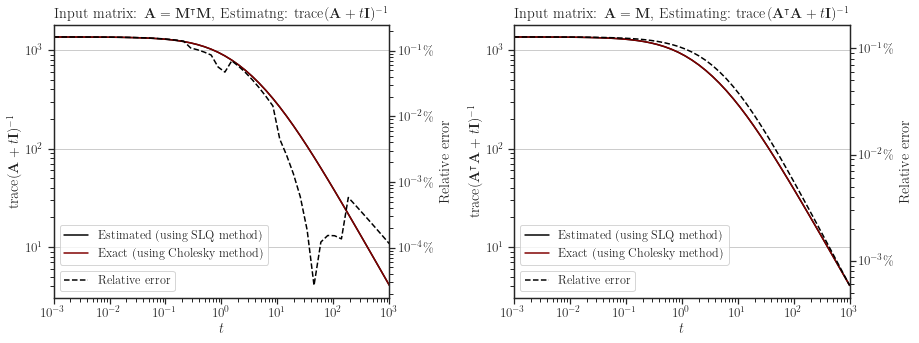

In [10]:
plot_figure('affine_matrix_function_traceinv', 'affine_matrix_function_traceinv_gram')

SLQ cpu_proc_time: 54.815700
Cholesky cpu_proc_time: 18.099638
SLQ cpu_proc_time: 103.426720
Cholesky cpu_proc_time: 23.589080
Plot saved to "affine_matrix_function_logdet.svg".


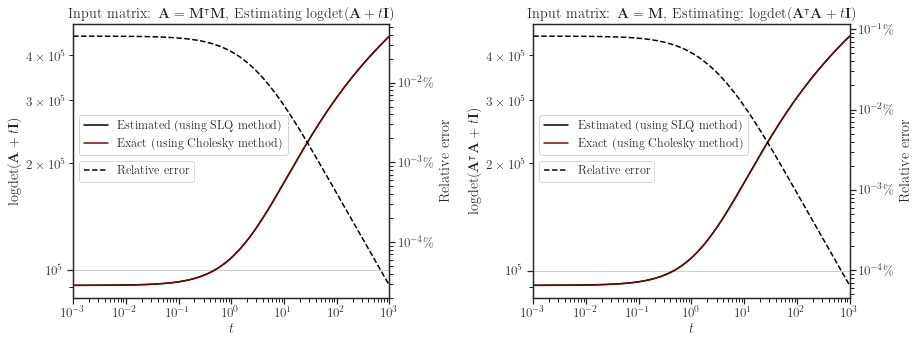

In [11]:
plot_figure('affine_matrix_function_logdet', 'affine_matrix_function_logdet_gram')